In [2]:
# Download the ZIP file from GitHub
!wget "https://github.com/DanielGHubs/Course-Project/raw/main/Healthy%20Grass%20vs%20Unhealthy%20Grass.zip" -O dataset.zip

# Unzip it
!unzip dataset.zip -d dataset/


--2025-11-13 02:20:49--  https://github.com/DanielGHubs/Course-Project/raw/main/Healthy%20Grass%20vs%20Unhealthy%20Grass.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DanielGHubs/Course-Project/main/Healthy%20Grass%20vs%20Unhealthy%20Grass.zip [following]
--2025-11-13 02:20:50--  https://raw.githubusercontent.com/DanielGHubs/Course-Project/main/Healthy%20Grass%20vs%20Unhealthy%20Grass.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2525486 (2.4M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   2.41M  --.-KB/s    in 0.06s   

2025-11-13 02:20

In [12]:
# =========================
# 📦 Setup: Imports & Device
# =========================

import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [13]:
# =========================
# 📂 Dataset & Dataloaders
# =========================

DATA_ROOT = "/content/dataset/Healthy Grass vs Unhealthy Grass"

def get_transforms(augment: bool):
    """Return transforms for dataset with optional augmentation."""

    if augment:
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    return train_transform, val_transform


def prepare_dataloaders(batch_size=32, augment=True):
    train_transform, val_transform = get_transforms(augment)

    train_dir = os.path.join(DATA_ROOT, "Train")
    test_dir = os.path.join(DATA_ROOT, "Test")

    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(test_dir, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    class_names = train_dataset.classes

    print("Classes:", class_names)
    print("Train samples:", len(train_dataset))
    print("Val samples:", len(val_dataset))

    return train_loader, val_loader, class_names

# Test
train_loader, val_loader, class_names = prepare_dataloaders()


Classes: ['Healthy', 'Unhealthy']
Train samples: 200
Val samples: 10


In [14]:
# =========================
# 🧠 Models: Simplified AlexNet + ResNet18
# =========================

class SimpleAlexNet(nn.Module):
    """A simplified AlexNet suitable for small datasets."""

    def __init__(self, num_classes=2):
        super(SimpleAlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(3, 2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(3, 2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(3, 2),
        )

        # Final feature map size = 6x6 with 256 channels
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 1024),
            nn.ReLU(True),

            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(True),

            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def build_model(arch, num_classes):
    if arch == "alexnet":
        return SimpleAlexNet(num_classes).to(device)
    elif arch == "resnet18":
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model.to(device)
    else:
        raise ValueError("Unknown architecture:", arch)


In [15]:
# =========================
# ⚙️ Training & Validation
# =========================

def train_one_epoch(model, optimizer, criterion, loader):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def evaluate(model, criterion, loader):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return running_loss / total, correct / total, np.array(all_labels), np.array(all_preds)


In [16]:
# =========================
# 🧪 Experiment Runner
# =========================

def run_experiment(
    arch="alexnet",
    batch_size=32,
    lr=1e-3,
    num_epochs=10,
    augment=True
):
    train_loader, val_loader, class_names = prepare_dataloaders(batch_size, augment)
    model = build_model(arch, num_classes=len(class_names))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    best_acc = 0
    best_labels = None
    best_preds = None
    best_state = None

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader)
        val_loss, val_acc, labels, preds = evaluate(model, criterion, val_loader)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch}/{num_epochs} | "
              f"Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_labels = labels
            best_preds = preds
            best_state = model.state_dict()

    # Save best model
    fname = f"best_{arch}_bs{batch_size}_lr{lr}_aug{augment}.pth"
    torch.save(best_state, fname)
    print("Best model saved:", fname)

    model.load_state_dict(best_state)

    return model, history, best_labels, best_preds, best_acc


In [17]:
# =========================
# 🎯 Baseline Experiment
# =========================

BASE_EPOCHS = 10

baseline_model, baseline_history, baseline_labels, baseline_preds, baseline_acc = run_experiment(
    arch="alexnet",
    batch_size=32,
    lr=1e-3,
    num_epochs=BASE_EPOCHS,
    augment=True
)

print("Baseline best accuracy:", baseline_acc)


Classes: ['Healthy', 'Unhealthy']
Train samples: 200
Val samples: 10
Epoch 1/10 | Train Acc: 0.460, Val Acc: 0.500
Epoch 2/10 | Train Acc: 0.485, Val Acc: 0.500
Epoch 3/10 | Train Acc: 0.570, Val Acc: 0.700
Epoch 4/10 | Train Acc: 0.720, Val Acc: 0.900
Epoch 5/10 | Train Acc: 0.795, Val Acc: 0.900
Epoch 6/10 | Train Acc: 0.820, Val Acc: 0.900
Epoch 7/10 | Train Acc: 0.795, Val Acc: 0.900
Epoch 8/10 | Train Acc: 0.870, Val Acc: 0.900
Epoch 9/10 | Train Acc: 0.820, Val Acc: 0.800
Epoch 10/10 | Train Acc: 0.875, Val Acc: 0.900
Best model saved: best_alexnet_bs32_lr0.001_augTrue.pth
Baseline best accuracy: 0.9


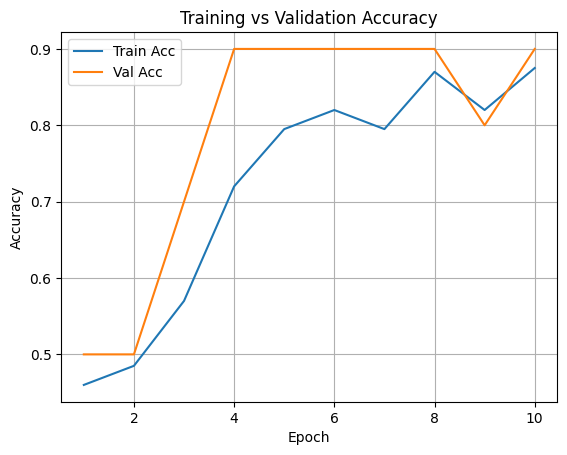

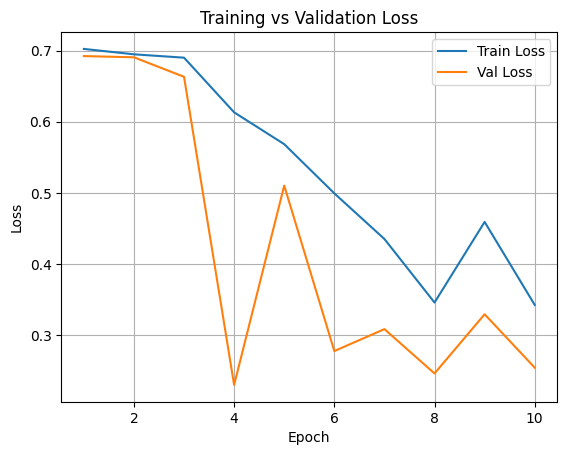

In [18]:
# =========================
# 📈 Graph 1 & 2
# =========================

epochs = range(1, BASE_EPOCHS + 1)

plt.plot(epochs, baseline_history["train_acc"], label="Train Acc")
plt.plot(epochs, baseline_history["val_acc"], label="Val Acc")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, baseline_history["train_loss"], label="Train Loss")
plt.plot(epochs, baseline_history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 500x500 with 0 Axes>

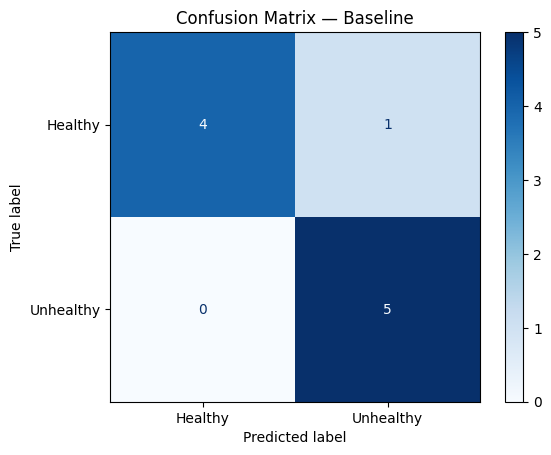

In [19]:
# =========================
# 📊 Graph 3 — Confusion Matrix
# =========================

cm = confusion_matrix(baseline_labels, baseline_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Baseline")
plt.show()



Batch size: 16
Classes: ['Healthy', 'Unhealthy']
Train samples: 200
Val samples: 10
Epoch 1/10 | Train Acc: 0.480, Val Acc: 0.400
Epoch 2/10 | Train Acc: 0.685, Val Acc: 0.800
Epoch 3/10 | Train Acc: 0.760, Val Acc: 0.700
Epoch 4/10 | Train Acc: 0.725, Val Acc: 0.900
Epoch 5/10 | Train Acc: 0.805, Val Acc: 0.900
Epoch 6/10 | Train Acc: 0.840, Val Acc: 0.900
Epoch 7/10 | Train Acc: 0.870, Val Acc: 0.900
Epoch 8/10 | Train Acc: 0.785, Val Acc: 0.900
Epoch 9/10 | Train Acc: 0.760, Val Acc: 0.900
Epoch 10/10 | Train Acc: 0.875, Val Acc: 0.900
Best model saved: best_alexnet_bs16_lr0.001_augTrue.pth

Batch size: 64
Classes: ['Healthy', 'Unhealthy']
Train samples: 200
Val samples: 10
Epoch 1/10 | Train Acc: 0.460, Val Acc: 0.500
Epoch 2/10 | Train Acc: 0.515, Val Acc: 0.900
Epoch 3/10 | Train Acc: 0.675, Val Acc: 0.600
Epoch 4/10 | Train Acc: 0.765, Val Acc: 0.600
Epoch 5/10 | Train Acc: 0.775, Val Acc: 0.900
Epoch 6/10 | Train Acc: 0.685, Val Acc: 0.900
Epoch 7/10 | Train Acc: 0.845, Val Ac

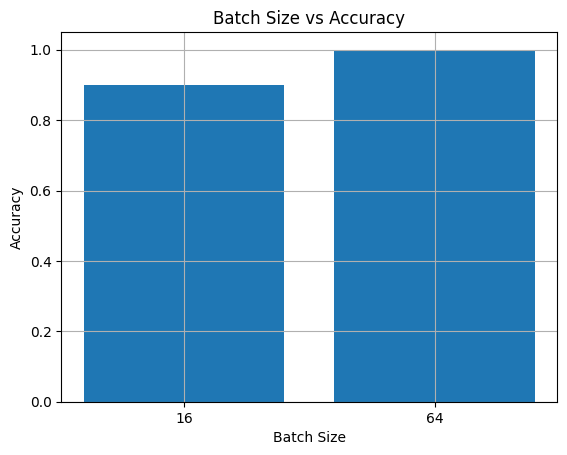

In [20]:
# =========================
# 🧪 Batch Size Experiment (Graph 4)
# =========================

batch_sizes = [16, 64]
batch_results = {}

for bs in batch_sizes:
    print("\nBatch size:", bs)
    _, _, _, _, acc = run_experiment(
        arch="alexnet",
        batch_size=bs,
        lr=1e-3,
        num_epochs=BASE_EPOCHS,
        augment=True
    )
    batch_results[bs] = acc

plt.bar([str(b) for b in batch_sizes], [batch_results[b] for b in batch_sizes])
plt.title("Batch Size vs Accuracy")
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()



Learning rate: 0.001
Classes: ['Healthy', 'Unhealthy']
Train samples: 200
Val samples: 10
Epoch 1/10 | Train Acc: 0.470, Val Acc: 0.500
Epoch 2/10 | Train Acc: 0.550, Val Acc: 0.500
Epoch 3/10 | Train Acc: 0.645, Val Acc: 0.900
Epoch 4/10 | Train Acc: 0.820, Val Acc: 0.900
Epoch 5/10 | Train Acc: 0.730, Val Acc: 0.500
Epoch 6/10 | Train Acc: 0.525, Val Acc: 0.800
Epoch 7/10 | Train Acc: 0.760, Val Acc: 0.900
Epoch 8/10 | Train Acc: 0.845, Val Acc: 1.000
Epoch 9/10 | Train Acc: 0.840, Val Acc: 0.900
Epoch 10/10 | Train Acc: 0.760, Val Acc: 1.000
Best model saved: best_alexnet_bs32_lr0.001_augTrue.pth

Learning rate: 0.0001
Classes: ['Healthy', 'Unhealthy']
Train samples: 200
Val samples: 10
Epoch 1/10 | Train Acc: 0.455, Val Acc: 0.500
Epoch 2/10 | Train Acc: 0.535, Val Acc: 0.600
Epoch 3/10 | Train Acc: 0.705, Val Acc: 0.900
Epoch 4/10 | Train Acc: 0.730, Val Acc: 0.900
Epoch 5/10 | Train Acc: 0.800, Val Acc: 0.900
Epoch 6/10 | Train Acc: 0.845, Val Acc: 0.900
Epoch 7/10 | Train Acc: 

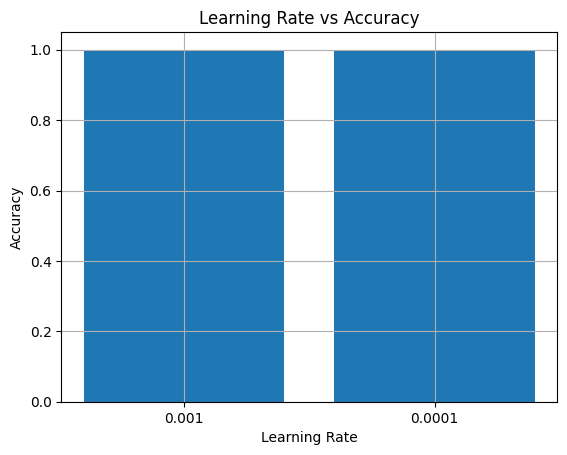

In [21]:
# =========================
# 🧪 Learning Rate Experiment (Graph 5)
# =========================

lrs = [1e-3, 1e-4]
lr_results = {}

for lr in lrs:
    print("\nLearning rate:", lr)
    _, _, _, _, acc = run_experiment(
        arch="alexnet",
        batch_size=32,
        lr=lr,
        num_epochs=BASE_EPOCHS,
        augment=True
    )
    lr_results[lr] = acc

plt.bar([str(lr) for lr in lrs], [lr_results[lr] for lr in lrs])
plt.title("Learning Rate vs Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [22]:
print("\nWith augmentation:")
_, _, _, _, acc_aug = run_experiment(
    arch="alexnet",
    batch_size=32,
    lr=1e-3,
    num_epochs=BASE_EPOCHS,
    augment=True
)

print("\nWithout augmentation:")
_, _, _, _, acc_no_aug = run_experiment(
    arch="alexnet",
    batch_size=32,
    lr=1e-3,
    num_epochs=BASE_EPOCHS,
    augment=False
)

print("\nAccuracy with augmentation:", acc_aug)
print("Accuracy WITHOUT augmentation:", acc_no_aug)



With augmentation:
Classes: ['Healthy', 'Unhealthy']
Train samples: 200
Val samples: 10
Epoch 1/10 | Train Acc: 0.445, Val Acc: 0.500
Epoch 2/10 | Train Acc: 0.500, Val Acc: 0.500
Epoch 3/10 | Train Acc: 0.635, Val Acc: 0.800
Epoch 4/10 | Train Acc: 0.735, Val Acc: 0.900
Epoch 5/10 | Train Acc: 0.740, Val Acc: 0.500
Epoch 6/10 | Train Acc: 0.650, Val Acc: 0.800
Epoch 7/10 | Train Acc: 0.840, Val Acc: 0.900
Epoch 8/10 | Train Acc: 0.730, Val Acc: 0.800
Epoch 9/10 | Train Acc: 0.825, Val Acc: 0.900
Epoch 10/10 | Train Acc: 0.845, Val Acc: 0.800
Best model saved: best_alexnet_bs32_lr0.001_augTrue.pth

Without augmentation:
Classes: ['Healthy', 'Unhealthy']
Train samples: 200
Val samples: 10
Epoch 1/10 | Train Acc: 0.535, Val Acc: 0.500
Epoch 2/10 | Train Acc: 0.590, Val Acc: 0.500
Epoch 3/10 | Train Acc: 0.500, Val Acc: 0.500
Epoch 4/10 | Train Acc: 0.500, Val Acc: 0.500
Epoch 5/10 | Train Acc: 0.535, Val Acc: 0.500
Epoch 6/10 | Train Acc: 0.700, Val Acc: 0.500
Epoch 7/10 | Train Acc: 0.

Classes: ['Healthy', 'Unhealthy']
Train samples: 200
Val samples: 10


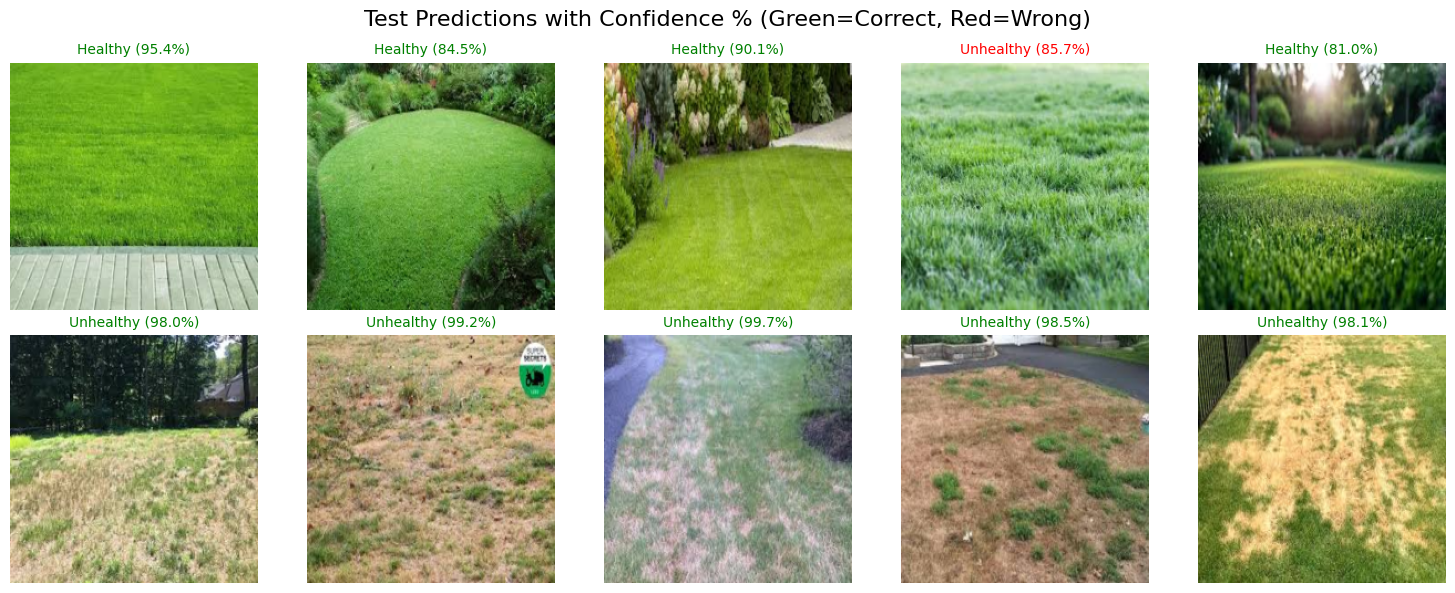

In [24]:
# =========================
# 🖼️ Graph 6: Test Predictions With Confidence
# =========================

import torch.nn.functional as F

# Load validation (test) loader again to ensure correct order
_, val_loader, class_names = prepare_dataloaders(batch_size=10, augment=False)

baseline_model.eval()

images_list = []
preds_list = []
labels_list = []
confs_list = []

# Collect predictions on test set
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = baseline_model(imgs)

        # Softmax → probabilities
        probs = F.softmax(outputs, dim=1)
        conf, preds = torch.max(probs, 1)

        images_list.extend(imgs.cpu())
        preds_list.extend(preds.cpu().numpy())
        labels_list.extend(labels.numpy())
        confs_list.extend(conf.cpu().numpy())

# -------------------------------
# Plot all test images in a grid
# -------------------------------

num_images = len(images_list)
cols = 5
rows = int(np.ceil(num_images / cols))

plt.figure(figsize=(15, 6))

for i in range(num_images):
    img = images_list[i].permute(1, 2, 0).numpy()
    true_label = class_names[labels_list[i]]
    pred_label = class_names[preds_list[i]]
    confidence = confs_list[i] * 100  # %

    is_correct = (true_label == pred_label)
    color = "green" if is_correct else "red"

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{pred_label} ({confidence:.1f}%)", color=color, fontsize=10)

plt.suptitle("Test Predictions with Confidence % (Green=Correct, Red=Wrong)", fontsize=16)
plt.tight_layout()
plt.show()
